# Notebook to calculate the modulation signal for the solar axion flux

The LPlasmon flux modulates because the axions are preferentially emitted out of the solar equator. The flux is proportional to $\sin^2{\theta_\oplus}$ which is the heliocentric polar angle position of the Earth. So the flux gets enhanced whenever the equatorial plane of the Sun and the orbital plane of the Earth (ecliptic) cross each other, which happens twice a year. 

To properly account for the eccentricity of the Earth's orbit we could expand in $e$ and work out all the formulae if we wanted, but probably the easiest thing to do is to just use astropy to get the RA and dec of the ecliptic as a function of time during the year

In [249]:
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body
import matplotlib.pyplot as plt
from numpy import *
import sys
sys.path.append('../src')
from Params import *
from PlotFuncs import *
import matplotlib.patheffects as pe

# Pick any location
loc = EarthLocation.of_site('greenwich') 

# Set array of times from Jan 1 2000 (Julian day = 2451544.5)
nt = 1000
days = linspace(0,365,nt)
t = Time(2451544.5+days,format='jd')

# Get properties of Sun (ra, dec and distance)
sun = get_body('sun', t, loc) 
sun_ra = sun.ra.value 
sun_dec = sun.dec.value 
sun_dist = sun.distance.value 

# Sanity check: plot RA and DEC of eclpitic as well as the equatorial plane of the Sun

We calculate the latter by taking the RA and DEC of the Solar north pole: (286.13,63.87) (thanks wikipedia), and then work out the circle at 90 degrees from that point that is projected on the celestial sphere. The declination of this equatorial circle we can calculate just using the RA values of the eclpitic we just calculated:
\begin{equation}
\delta^{\rm eq}(\alpha) = -(90^\circ-\delta^{\rm NP}_\odot) \,\cos(\alpha - \alpha_\odot)
\end{equation}

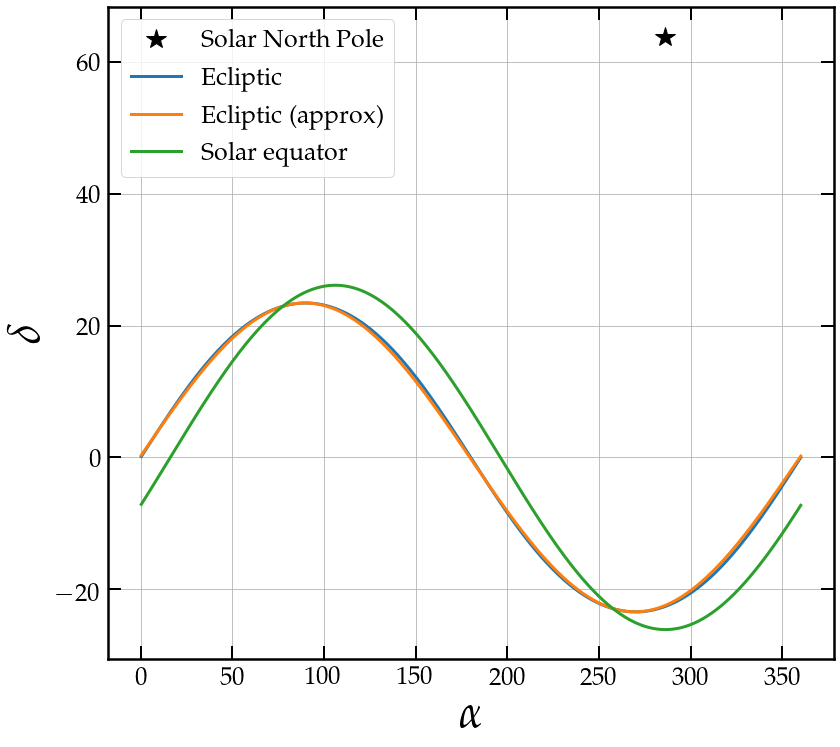

In [250]:
fig,ax = MySquarePlot(r'$\alpha$',r'$\delta$')

# Solar north pole:
sun_eq_ra = 286.13
sun_eq_dec = 63.87 
plt.plot(sun_eq_ra,sun_eq_dec,'k*',markersize=20,label='Solar North Pole')


# Plot eclpitic plane:
plt.plot(sun_ra[argsort(sun_ra)],sun_dec[argsort(sun_ra)],'-',label='Ecliptic',lw=3)

# Another sanity check: approximate the eclpitic at lowest order in e:
sun_dec_approx = 23.44*cos(pi*(sun_ra-89.5)/180)
plt.plot(sun_ra[argsort(sun_ra)],sun_dec_approx[argsort(sun_ra)],'-',label='Ecliptic (approx)',lw=3)

# Solar equator
equator_dec = -(90-sun_eq_dec)*cos(pi*(sun_ra-sun_eq_ra)/180)
plt.plot(sun_ra[argsort(sun_ra)],equator_dec[argsort(sun_ra)],'-',label='Solar equator',lw=3)

plt.legend()
plt.grid()

MySaveFig(fig,'CelestialSphere_angle_check')

# Now we make the plot for the paper which calculates the great circle angle between the eclpitic and the projected solar equator

We take into accounte the modulation of $\sin^2{\theta_\oplus}$ by finding $\theta_\oplus = \pi/2 - \theta_{\rm ecl}$ where $\theta_{\rm ecl}$ is the great angle distance between the ($\delta^{\rm eq}_\odot(t),\alpha^{\rm eq}_\odot(t)$) and $(\alpha_{\rm ecl},\delta_{\rm ecl})$ (in practice we can just subtract the two $\delta$'s since we calculated one using the RA's of the other, but the full formula is there nevertheless)

We also calculate the modulation due to $1/r^2$ using the distance we calculated earlier.

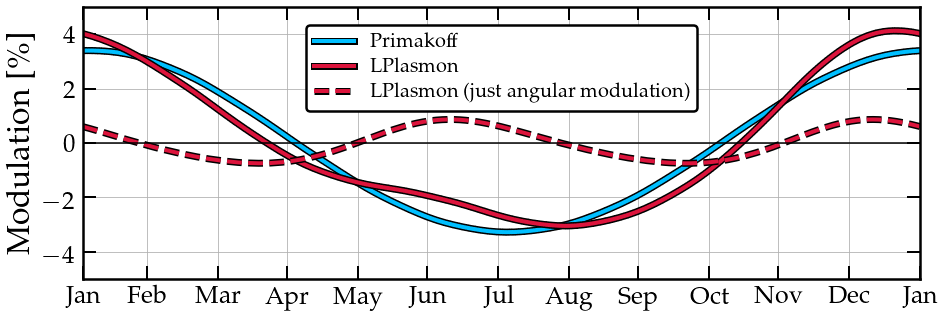

In [251]:
pef= [pe.Stroke(linewidth=7, foreground='k'), pe.Normal()]


fig,ax = MySquarePlot('',r'Modulation [\%]',size_x=15,size_y=5,lfs=32)


# Great angle distance
th_ecl = arccos(sin(sun_dec*pi/180)*sin(equator_dec*pi/180)+cos(sun_dec*pi/180)*cos(equator_dec*pi/180)*cos(pi/180*abs(sun_ra-sun_ra)))

# Earth's heliocentric polar angle 
th_E = pi/2-th_ecl


# Just the distance modulation for the Primakoff flux:
mod2 = 1.0/sun_dist**2.0
plt.plot(days,100*(mod2-mean(mod2))/mean(mod2),label='Primakoff',lw=4,color='deepskyblue',path_effects=pef)

# The Lplasmon modulation has both effects
mod3 = sin(th_E)**2.0/sun_dist**2.0
plt.plot(days,100*(mod3-mean(mod3))/mean(mod3),label='LPlasmon',lw=4,color='crimson',path_effects=pef)


# Isolate just the B-field induced modulation:
mod1 = sin(th_E)**2.0
plt.plot(days,100*(mod1-mean(mod1))/mean(mod1),'--',label=r'LPlasmon (just angular modulation)',lw=4,color='crimson',path_effects=pef)



# Some cosmetic tweaks
leg = plt.legend(fontsize=20,frameon=True,loc='upper center',framealpha=1,edgecolor='k',labelspacing=0.2,bbox_to_anchor=(0.5,0.97))
leg.get_frame().set_linewidth(2.5)
plt.grid()
plt.xlim([0,365])
plt.ylim([-5,5])
ax.axhline(0,color='k')


# Add ticks for the months
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan']
monthsi = cumsum([31,28,31,30,31,30,31,31,30,31,30,31,31])-31
ax.set_xticks(monthsi)
ax.set_xticklabels(months)

MySaveFig(fig,'Modulation')
